In [1]:
import pandas as pd

df = pd.read_csv("meal_features_cleaned.csv")


In [2]:
import plotly.express as px

for col in ["calories", "protein_g", "carbs_g", "fat_g", "fiber_g"]:
    fig = px.histogram(df, x=col, nbins=30,
                       marginal="box",  # adds a boxplot above
                       title=f"Distribution of {col}",
                       color_discrete_sequence=["teal"])
    fig.update_layout(
        width=600,
        height=400,
        title_x=0.5,
        template="plotly_white"
    )
    fig.show()


## Summary of Nutrient Distributions

* All three nutrients — fiber, carbs, and fat — show right-skewed distributions.
* Most food items have low nutrient content, while a few are high in nutrients.
* Fiber: Majority below 1 g, few reach up to 4 g (high-fiber foods).
* Carbs: Most under 20 g, with some outliers above 60 g (high-carb foods).
* Fat: Majority below 5 g, few extend above 20 g (high-fat foods like oils).
* No major outliers beyond upper fences — data appears clean and accurate.
This distribution pattern is typical of real-world nutritional data.


In [3]:
import plotly.express as px

# Compute correlation matrix
corr = df.corr()

# Create heatmap
fig = px.imshow(
    corr,
    text_auto=True,       # shows correlation values
    color_continuous_scale="RdBu_r",  # similar to coolwarm
    title="Feature Correlation Heatmap",
    aspect="auto"
)

fig.update_layout(
    width=800,
    height=600,
    title_x=0.5,
    template="plotly_white"
)

fig.show()



###Correlation

Calories show strong positive correlation with both fat and carbohydrates, indicating these two nutrients are the main drivers of total calorie content.
Protein has a moderate correlation with calories and fat, suggesting it contributes to energy but less strongly.
Fiber is weakly correlated with other features, meaning it can be increased independently without significantly affecting calories.

In [4]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Select only the numeric feature columns
X_features = df[["calories", "protein_g", "carbs_g", "fat_g", "fiber_g"]].values

models = {
    "KMeans": KMeans(n_clusters=4, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=4),
    "DBSCAN": DBSCAN(eps=5, min_samples=5),  # tune eps/min_samples
    "GMM": GaussianMixture(n_components=4, random_state=42)
}

results = []

for name, model in models.items():
    # Some models like GMM need a different call
    if name == "GMM":
        labels = model.fit_predict(X_features)
    else:
        labels = model.fit_predict(X_features)

    if len(set(labels)) > 1:  # avoid metric errors if DBSCAN finds only 1 cluster
        silhouette = silhouette_score(X_features, labels)
        ch_score = calinski_harabasz_score(X_features, labels)
        db_score = davies_bouldin_score(X_features, labels)
    else:
        silhouette, ch_score, db_score = None, None, None

    results.append({
        "Model": name,
        "Silhouette": silhouette,
        "Calinski-Harabasz": ch_score,
        "Davies-Bouldin": db_score
    })

df_results = pd.DataFrame(results)
print(df_results)




           Model  Silhouette  Calinski-Harabasz  Davies-Bouldin
0         KMeans    0.543508       51181.073391        0.615238
1  Agglomerative    0.495608       47021.454595        0.626650
2         DBSCAN   -0.567607         377.692571        2.554620
3            GMM    0.189626        7528.184398        1.781635


In [5]:
import plotly.express as px

# Assuming df_results is the DataFrame from your code
fig = px.bar(
    df_results,
    x="Model",
    y="Silhouette",
    color="Model",
    text="Silhouette",
    color_discrete_sequence=["#2E8B57", "#A3C1AD", "#D4B483", "#7FB3D5"],  # green & beige tones
    title="Silhouette Score Comparison Across Clustering Models"
)

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(
    xaxis_title="Clustering Algorithm",
    yaxis_title="Silhouette Score",
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(size=13),
    title_font=dict(size=16, family="Arial", color="black"),
    yaxis=dict(showgrid=True, gridcolor="lightgray")
)

fig.show()


In [6]:
import plotly.express as px
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_features)

# Create a list to hold all figures
figs = []

for name, model in models.items():
    labels = model.fit_predict(X_features)
    df_pca = pd.DataFrame({
        "PCA1": X_pca[:, 0],
        "PCA2": X_pca[:, 1],
        "Cluster": labels
    })

    fig = px.scatter(
        df_pca,
        x="PCA1",
        y="PCA2",
        color=df_pca["Cluster"].astype(str),
        title=f"{name} Clustering (PCA Projection)",
        color_discrete_sequence=px.colors.qualitative.Set2
    )

    fig.update_layout(
        width=600,
        height=500,
        title_x=0.5,
        template="plotly_white"
    )
    fig.show()



* KMeans and Agglomerative Clustering best capture the dataset’s structure, forming clear and interpretable clusters in the PCA space.
* DBSCAN struggles with over-fragmentation, implying non-uniform density.
GMM performs decently but produces overlapping clusters, which might complicate interpretation.
* Best choice: KMeans or Agglomerative Clustering — both provide clean separation and meaningful groupings for this dataset.

In [7]:
import plotly.graph_objects as go
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

scores_kmeans = []
scores_agglom = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels_km = km.fit_predict(df)
    scores_kmeans.append(silhouette_score(df, labels_km))

    ac = AgglomerativeClustering(n_clusters=k)
    labels_ac = ac.fit_predict(df)
    scores_agglom.append(silhouette_score(df, labels_ac))

# Create interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(K), y=scores_kmeans,
    mode='lines+markers',
    name='KMeans',
    marker=dict(symbol='circle', size=8),
    line=dict(color='royalblue', width=2)
))

fig.add_trace(go.Scatter(
    x=list(K), y=scores_agglom,
    mode='lines+markers',
    name='Agglomerative',
    marker=dict(symbol='square', size=8),
    line=dict(color='firebrick', width=2)
))

fig.update_layout(
    title="KMeans vs Agglomerative Clustering (Silhouette Analysis)",
    xaxis_title="Number of Clusters (k)",
    yaxis_title="Silhouette Score",
    template="plotly_white",
    title_x=0.5,
    width=800,
    height=500
)

fig.show()


k = 4 provides a strong trade-off between cluster separation and interpretability. It maintains a good silhouette score and yields well-defined, meaningful clusters in both KMeans and Agglomerative methods.

In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go

# --- Preprocessing ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)  # assuming df = your nutrition dataframe

# --- KMeans clustering with k=4 ---
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# --- Cluster Means ---
cluster_means = df.groupby('Cluster').mean().reset_index()
print("Cluster Means:\n", cluster_means)

# ======================
# 1️⃣ Donut Chart (Cluster Distribution)
# ======================
cluster_counts = df['Cluster'].value_counts().sort_index().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

fig_donut = px.pie(
    cluster_counts,
    names='Cluster',
    values='Count',
    hole=0.4,
    title='Meal Cluster Distribution (KMeans k=4)',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig_donut.update_traces(textposition='inside', textinfo='percent+label')
fig_donut.show()

# ======================
# 2️⃣ Radar Chart (Cluster Nutrition Profiles)
# ======================

# normalize cluster means for fair comparison
normalized_means = cluster_means.copy()
for col in cluster_means.columns[1:]:
    normalized_means[col] = cluster_means[col] / cluster_means[col].max()

categories = normalized_means.columns[1:]  # exclude 'Cluster'

fig_radar = go.Figure()

for i, row in normalized_means.iterrows():
    fig_radar.add_trace(go.Scatterpolar(
        r=row[categories].values,
        theta=categories,
        fill='toself',
        name=f'Cluster {int(row["Cluster"])}'
    ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1])
    ),
    title="Normalized Nutrition Profile by Cluster",
    showlegend=True
)

fig_radar.show()


Cluster Means:
    Cluster    calories  protein_g    carbs_g      fat_g   fiber_g
0        0  370.512754   8.391150  52.323114  14.680518  3.496984
1        1   66.966615   2.719711   9.258039   2.032363  0.730788
2        2  335.365883   3.450713  65.192185   7.544693  0.659572
3        3  211.252331  17.480629   5.792886  12.880464  0.382928


In [10]:
import pandas as pd
from sklearn.cluster import KMeans

# Assuming X is a DataFrame
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)

# Add cluster labels to your DataFrame
df['Cluster'] = labels

# Compute mean of each cluster
cluster_means = df.groupby('Cluster').mean()
print(cluster_means)


           calories  protein_g    carbs_g      fat_g   fiber_g
Cluster                                                       
0        479.470076   7.187750  59.233031  23.514668  2.556507
1         55.020944   4.068058   7.388167   1.233992  0.618112
2        332.709774   9.563921  45.492266  12.488258  1.459513
3        188.329587  11.344988  15.148511   9.033147  1.046153


<Figure size 1000x600 with 0 Axes>

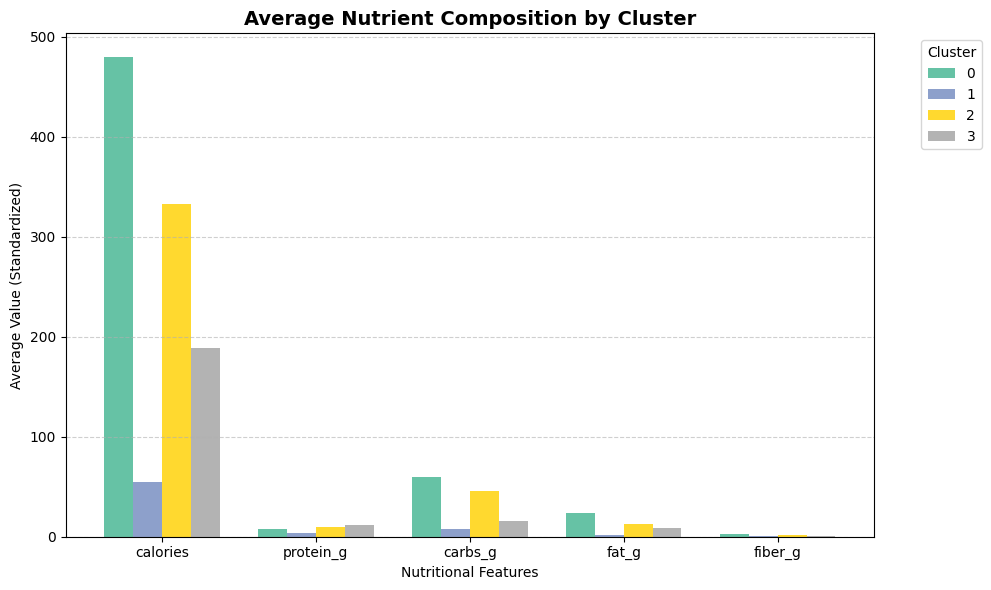

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Assuming df is your preprocessed DataFrame
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)

# Add cluster labels to DataFrame
df['Cluster'] = labels

# Compute cluster means
cluster_means = df.groupby('Cluster').mean()

# Plot cluster mean comparison
plt.figure(figsize=(10, 6))
cluster_means.T.plot(kind='bar', figsize=(10, 6), colormap='Set2', width=0.75)

plt.title('Average Nutrient Composition by Cluster', fontsize=14, weight='bold')
plt.ylabel('Average Value (Standardized)')
plt.xlabel('Nutritional Features')
plt.xticks(rotation=0)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [12]:
import plotly.graph_objects as go

# Common style settings
def make_donut(labels, values, title):
    fig = go.Figure(
        data=[go.Pie(
            labels=labels,
            values=values,
            hole=0.4,
            textinfo='label+percent',        # ✅ show labels + %
            textfont_size=14,
            insidetextorientation='radial',  # ✅ keeps text readable
            marker=dict(line=dict(color='white', width=2))
        )]
    )
    fig.update_layout(
        title_text=title,
        showlegend=False,                   # ✅ remove legend
        title_x=0.5,                        # center title
        title_font=dict(size=18)
    )
    fig.show()

# Cluster 0 – Carb-Dense Balanced Meals (Weight Gain)
make_donut(
    ["protein_g", "carbs_g", "fat_g", "fiber_g"],
    [7.187750,  59.233031,  23.514668,  2.556507],
    "Carb-Dense Balanced Meals — Ideal for Weight Gain"
)

# Cluster 1 – Low-Calorie Light Foods (Weight Loss)
make_donut(
    ["protein_g", "carbs_g", "fat_g", "fiber_g"],
    [4.068058,   7.388167,   1.233992 , 0.618112],
    "Low-Calorie Light Foods — Ideal for Weight Loss"
)

# Cluster 2 – Protein-Rich Balanced Meals (Maintenance)
make_donut(
    ["protein_g", "carbs_g", "fat_g", "fiber_g"],
    [ 9.563921 , 45.492266 , 12.488258 , 1.459513],
    "Protein-Rich Balanced Meals — Ideal for Maintenance"
)

# Cluster 3 – High-Protein Energy Meals (Maintenance / Gain)
make_donut(
    ["protein_g", "carbs_g", "fat_g", "fiber_g"],
    [11.344988 , 15.148511 ,  9.033147  ,1.046153],
    "High-Protein Energy Meals — Ideal for Maintenance or Muscle Gain"
)


In [13]:
cluster_labels = {
    0: "Carb-Dense Balanced Meals — Ideal for Weight Gain",
    1: "Low-Calorie Light Foods — Ideal for Weight Loss",
    2: "Protein-Rich Balanced Meals — Ideal for Maintenance",
    3: "High-Protein Energy Meals — Ideal for Maintenance or Muscle Gain"}

df["meal_type"] = df["Cluster"].map(cluster_labels)



###FINAL DATASET

In [14]:
df.head(5)

,calories,protein_g,carbs_g,fat_g,fiber_g,Cluster,meal_type
0,177.0,21.24,7.46,6.12,0.0,3,High-Protein Energy Meals — Ideal for Maintena...
1,172.0,16.89,8.14,7.66,0.4,3,High-Protein Energy Meals — Ideal for Maintena...
2,181.0,17.69,8.86,7.94,0.2,3,High-Protein Energy Meals — Ideal for Maintena...
3,310.0,0.09,76.37,0.45,0.2,2,Protein-Rich Balanced Meals — Ideal for Mainte...
4,88.0,0.21,2.10,2.38,0.0,1,Low-Calorie Light Foods — Ideal for Weight Loss


In [17]:
original_df = pd.read_csv("original.csv")

In [18]:
# Align them by index
merged_df = pd.concat([original_df[["description", "dataType"]], df], axis=1)

# Save the new dataset
merged_df.to_csv("merged.csv", index=False)

print(merged_df.head())

              description        dataType  calories  protein_g  carbs_g  \
0                 Abalone  Survey (FNDDS)     177.0      21.24     7.46   
1     Adobo, with noodles  Survey (FNDDS)     172.0      16.89     8.14   
2        Adobo, with rice  Survey (FNDDS)     181.0      17.69     8.86   
3  Agave liquid sweetener  Survey (FNDDS)     310.0       0.09    76.37   
4  Alcoholic coffee drink  Survey (FNDDS)      88.0       0.21     2.10   

   fat_g  fiber_g  Cluster                                          meal_type  
0   6.12      0.0      3.0  High-Protein Energy Meals — Ideal for Maintena...  
1   7.66      0.4      3.0  High-Protein Energy Meals — Ideal for Maintena...  
2   7.94      0.2      3.0  High-Protein Energy Meals — Ideal for Maintena...  
3   0.45      0.2      2.0  Protein-Rich Balanced Meals — Ideal for Mainte...  
4   2.38      0.0      1.0    Low-Calorie Light Foods — Ideal for Weight Loss  
